In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold

from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score

# Trainando o modelo

In [4]:
df = pd.read_csv("../datasets/processed/processed_df.csv", index_col='udi', low_memory=False)

In [106]:
df

,type,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type,diff_temperature_k
udi,,,,,,
1,M,1551,42.8,0,No Failure,10.5
2,L,1408,46.3,3,No Failure,10.5
5,L,1408,40.0,9,No Failure,10.5
6,M,1425,41.9,11,No Failure,10.5
7,L,1558,42.4,14,No Failure,10.5
...,...,...,...,...,...,...
9995,L,1634,27.9,12,No Failure,9.5
9996,M,1604,29.5,14,No Failure,9.6
9997,H,1632,31.8,17,No Failure,9.5


In [5]:
features = df.drop(columns='failure_type')
target = df.failure_type

In [6]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
encoder = LabelEncoder()

# Fit and transform the target column
target_encoded = encoder.fit_transform(df['failure_type'])

# Create a DataFrame from the target_onehot array
target_df = pd.DataFrame(target_encoded.reshape(-1,1), index=df.index, columns=['failure_type'])

# Replace the values 0, 2, 3, and 4 in the 'failure_type' column with 0
target_df.loc[target_df['failure_type'].isin([0, 2, 3, 4]), 'failure_type'] = 0



In [7]:
target_df.value_counts()

failure_type
1               6447
0                220
dtype: int64

In [8]:
train_x, test_x, train_y, test_y = train_test_split(features, target_df, test_size=0.4)

In [9]:
#Cria o processamento como uma função

def create_model(algorithm):
    #define como transforma cada coluna para poder rodar no modelo de ML
    numeric_features = ['rotational_speed_rpm', 'torque_nm', 'tool_wear_min', 'diff_temperature_k']
    numeric_transformer = SimpleImputer(strategy="median")

    #Exemplo de transformar a coluna não numerica com ordem para intervalo valores.
    ordinal_features = ['type'] #não acho que é ordinal
    ordinal_transformer = OrdinalEncoder()

    # #Exemplo de transformar uma coluna sem ordem para numerica.
    # categorical_features = ["embarked", "pclass"]
    # categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    
    #Cria o pipeline de transformações de coluna com as informações a cima
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("le", ordinal_transformer, ordinal_features),
            #("ohe", categorical_transformer, categorical_features)
        ]
    )
    
    #Execut o pipeline acima e tbm normaliza, roda PCA e um modelo (que a função recebe)
    return Pipeline(
        steps=[
            ("preprocessor", preprocessor), 
            ("scaler", StandardScaler()), #normaliza
            ("PCA", PCA(n_components=.95)), #PCA
            ("classifier", algorithm) #Modelo (que a função recebe)
        ]
    )

In [10]:
def experiment_v2(model, features, target_df, n_splits=5):
    kf = KFold(n_splits=n_splits)

    scores = dict(
        train_count = list(),
        train_true_percent = list(),
        train_scores = list(),
        valid_count = list(),
        valid_true_percent = list(),
        valid_scores = list()
    )
    

    for train_index, valid_index in kf.split(features):
        train_x, train_y = features.iloc[train_index], target_df.iloc[train_index]
        valid_x, valid_y = features.iloc[valid_index], target_df.iloc[valid_index]
        
        model.fit(train_x, train_y)

        fold_train_score = roc_auc_score(train_y, model.predict(train_x))
        fold_valid_score = roc_auc_score(valid_y, model.predict(valid_x))

        # Salva vários parâmetrosde medição
        scores['train_count'].append(train_x.shape[0])
        scores['valid_count'].append(valid_x.shape[0])
        scores['train_true_percent'].append(train_y.sum() / train_y.shape[0])
        scores['valid_true_percent'].append(valid_y.sum() / valid_y.shape[0])

        scores['train_scores'].append(fold_train_score)
        scores['valid_scores'].append(fold_valid_score)
    
    return pd.DataFrame(scores)

In [11]:
def plot_validation_curve(results, title, ax):
    x = np.arange(results.shape[0])

    ax.plot(x, results.train_scores, 'o-', label='Training Score')
    ax.plot(x, results.valid_scores, 'o-', label='Validation Score')

    ax.set_title(title)
    ax.set_ylim(.65, 1)
    ax.legend()
    ax.grid()

/Users/Cesar-mac/miniconda3/envs/.grupo-00-venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Cesar-mac/miniconda3/envs/.grupo-00-venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Cesar-mac/miniconda3/envs/.grupo-00-venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Cesar-mac/miniconda3/envs/.grupo-00-venv/lib/python3.10/site-packages/sklearn/utils/validatio

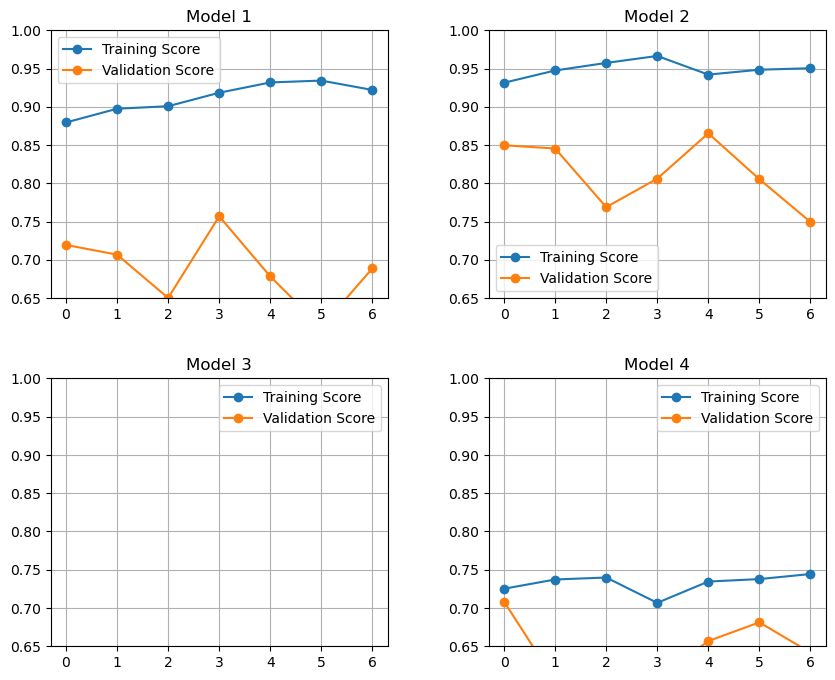

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

models = {
    "Model 1": create_model(DecisionTreeClassifier(max_depth=10)),
    "Model 2": create_model(DecisionTreeClassifier(
        class_weight='balanced',
        criterion='log_loss',
        max_depth=7,
        min_samples_leaf=5,
        min_samples_split=2
    )),
    "Model 3": create_model(LogisticRegression()),
    "Model 4": create_model(KNeighborsClassifier(n_neighbors=5))
}

model_results = list()
for ax, (model_name, model) in zip([ax1, ax2, ax3, ax4], models.items()):
    results = experiment_v2(model, features, target_df, n_splits=7)
    results['model'] = model_name
    model_results.append(results)

    plot_validation_curve(results, model_name, ax)
model_results = pd.concat(model_results, axis=0)

plt.subplots_adjust(wspace=.3, hspace=.3)
plt.show()

In [13]:
(model_results
 .groupby('model', as_index=False)
 .agg({
    'train_scores': ['mean', 'std', 'min', 'max'],
    'valid_scores': ['mean', 'std', 'min', 'max']
})).round(3)

model train_scores                      valid_scores                     
                   mean    std    min    max         mean    std    min    max
0  Model 1        0.912  0.020  0.880  0.934        0.688  0.047  0.612  0.757
1  Model 2        0.949  0.011  0.931  0.966        0.813  0.043  0.750  0.865
2  Model 3        0.503  0.002  0.500  0.505        0.500  0.000  0.500  0.500
3  Model 4        0.732  0.013  0.707  0.744        0.644  0.041  0.605  0.708

## O modelo que teve melhor desempenho foi o modelo 2.

In [19]:
model = models['Model 2']

In [20]:
import pickle

# Save the model to a file
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)


# Treinando o teste

In [14]:
classifier = models['Model 2']

In [21]:
df = pd.read_csv("../datasets/processed/processed_teste.csv", index_col='udi', low_memory=False)

In [23]:
y_pred = classifier.predict(df)

In [24]:
y_pred_df = pd.DataFrame(y_pred)

In [25]:
y_pred_df.value_counts()

1    3061
0     272
dtype: int64

In [26]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
df

,type,rotational_speed_rpm,torque_nm,tool_wear_min,diff_temperature_k
udi,,,,,
446,L,1793,26.7,70,11.1
7076,L,1536,47.4,192,9.8
1191,L,1460,42.1,41,11.2
2618,L,1670,35.9,68,9.7
5067,L,1550,30.9,9,9.0
...,...,...,...,...,...
5554,L,1306,59.7,172,9.4
6961,L,1413,52.0,91,10.3
6914,L,1481,38.5,181,10.4


In [31]:
# Create the DataFrame
result_df = pd.DataFrame({'predictedValues': y_pred})
result_df['rowNumber'] = df.index

# Reset the index of the DataFrame
result_df = result_df.reset_index(drop=True)

In [32]:
result_df

,predictedValues,rowNumber
0,1,446
1,1,7076
2,1,1191
3,1,2618
4,1,5067
...,...,...
3328,1,5554
3329,1,6961
3330,1,6914
3331,1,5510


In [33]:
result_df.to_csv('../predicted.csv')